循环神经网络的三种技巧：   
* 循环dropout,降低过拟合   
* 堆叠循环层，提高网络的表示能力，代价是更高的计算负荷   
* 双向循环层，将相同的信息以不同的方式呈现给循环网络，可以提高精度以缓解遗忘问题

# 温度预测问题

In [1]:
# 观察天气数据集的数据
import os
data_dir = r'./data'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

with open(fname,'r') as f:
    data = f.read()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [6]:
type(lines)

list

In [2]:
# 将数据转换为一个Numpy数组
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

In [8]:
float_data[0]

array([  9.96520000e+02,  -8.02000000e+00,   2.65400000e+02,
        -8.90000000e+00,   9.33000000e+01,   3.33000000e+00,
         3.11000000e+00,   2.20000000e-01,   1.94000000e+00,
         3.12000000e+00,   1.30775000e+03,   1.03000000e+00,
         1.75000000e+00,   1.52300000e+02])

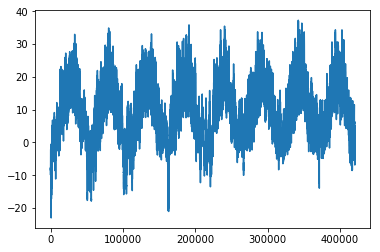

In [10]:
# 绘制温度时间序列
%matplotlib inline
import matplotlib.pyplot as plt
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

## 准备数据

以天为观察尺度，原数据一个时间步是10分钟，每steps个时间步采样一次数据，给定过lookback个时间步之内的数据，能够预测delay个时间步之后的温度

### 数据标准化

In [3]:
mean = float_data[:20000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std

### 生成时间序列样本及其目标的生成器

In [4]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    """
    data:       浮点数据组成的原始数组，标准化之后
    lookback:   输入数据应该包括过去多少个时间步
    delay:      目标标应该在未来多少个时间步之后
    min_index:  data数组中的索引，用于界定需要抽取哪些时间步，有助于保存一部分用于验证和测试
    shuffle:    是打乱样本， 否按顺序抽取样本
    batch_size: 每个批量的样本数
    step:       数据采样的周期，单位是时间步，设置为6就是每小时抽取一个数据点
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index , size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

## 准备训练生成器、验证生成器和测试生成器

In [5]:
lookback =1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(data=float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = 200000,
                     shuffle = True,
                     step = step,
                     batch_size = batch_size)

val_gen = generator(data=float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 200001,
                     max_index = 300000,
                     
                     step = step,
                     batch_size = batch_size)

test_gen = generator(data=float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     
                     step = step,
                     batch_size = batch_size)

In [6]:
val_steps = (300000 - 200001 - lookback) // batch_size
print(val_steps)

test_steps = (len(float_data) - 300001 - lookback) // batch_size
print(test_steps)

769
930


   ### 计算符合常识的基准方法MAE

一种基于常识的方法就是始终预测24小时候的温度等于现在的温度，下面评估这个常识的MAE

In [7]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples , targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        
    print(np.mean(batch_maes))

In [8]:
evaluate_naive_method()

0.335517562862


In [23]:
celsius_mae = 0.335518 * std[1]
print(celsius_mae)

2.56489077671


In [24]:
print(np.random.randint(1,10,2))

[8 3]


## 使用简单机器学习方法学习

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 1.0973 - val_loss: 0.5564
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.4693 - val_loss: 0.4842
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3352 - val_loss: 0.3898
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3012 - val_loss: 0.3877
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2835 - val_loss: 0.4095
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2725 - val_loss: 0.3987
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2639 - val_loss: 0.4049
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2564 - val_loss: 0.3876
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2504 - val_loss: 0.3890
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2446 - val_l

## 第一个循环网络基准

### 训练并评估一个基于GRU的模型

In [11]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
# model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 142s 283ms/step - loss: 0.3669 - val_loss: 0.3145
Epoch 2/20
500/500 [==============================] - 142s 284ms/step - loss: 0.3298 - val_loss: 0.3076
Epoch 3/20
 81/500 [===>..........................] - ETA: 1:32 - loss: 0.3260

KeyboardInterrupt: 